In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from system_dynamics import Sys_dynamics
from tqdm import tqdm

In [2]:
# define actor
class Actor(nn.Module):
    def __init__(self, n_state, n_control, n_nn_a, u_b):
        super(Actor, self).__init__()
        self.n_state = n_state
        self.n_control = n_control
        self.n_nn = n_nn_a
        self.u_b = u_b
        self.linear1 = nn.Linear(self.n_state, self.n_nn,bias=False)
        self.linear2 = nn.Linear(self.n_nn, self.n_nn,bias=False)
        self.linear3 = nn.Linear(self.n_nn, self.n_control,bias=False)
        # no bias because when x = 0, u = 0

    def forward(self, state):
        output = torch.tanh(self.linear1(state))
        output = torch.tanh(self.linear2(output))
        D_nn = self.linear3(output)
        output = self.u_b*torch.tanh(D_nn)
        # output through the bounding layer
        return output, D_nn

In [3]:
# define critic
class Critic(nn.Module):
    def __init__(self, n_state, n_nn_c):
        super(Critic, self).__init__()
        self.n_state = n_state
        self.n_nn = n_nn_c
        self.linear1 = nn.Linear(self.n_state, self.n_nn, bias=False)
        self.linear2 = nn.Linear(self.n_nn, self.n_nn, bias=False)
        self.linear3 = nn.Linear(self.n_nn, n_state, bias=False)

        # no bias because when x = 0, u = 0

    def forward(self, state):
        output = torch.tanh(self.linear1(state))
        output = torch.tanh(self.linear2(output))
        output = self.linear3(output)
        # no bounding layer
        return output

In [4]:
# config networks
n_nn_c = 10
n_nn_a = 10


# system settings
n_state = 6
n_control = 2
u_b = 20*np.pi/180 # input constraints

actor = Actor(n_state= n_state, n_control=n_control,n_nn_a=n_nn_a, u_b=u_b)
critic = Critic(n_state= n_state, n_nn_c=n_nn_c)

print(actor)
print(critic)

sys_dynamics = Sys_dynamics() # instantiation

Actor(
  (linear1): Linear(in_features=6, out_features=10, bias=False)
  (linear2): Linear(in_features=10, out_features=10, bias=False)
  (linear3): Linear(in_features=10, out_features=2, bias=False)
)
Critic(
  (linear1): Linear(in_features=6, out_features=10, bias=False)
  (linear2): Linear(in_features=10, out_features=10, bias=False)
  (linear3): Linear(in_features=10, out_features=6, bias=False)
)


In [5]:
# define trianing iterations
def train_iters(actor, critic, state_now, Q, R, gamma_c, num_epochs, dt):
# NNs are trained within this function
# outside this function, no torch is used

    optimizer_actor = torch.optim.SGD(actor.parameters(), lr = 0.0001)
    optimizer_critic = torch.optim.SGD(critic.parameters(), lr = 0.0001)
    loss_actor_fn = torch.nn.MSELoss()
    loss_critic_fn = torch.nn.MSELoss()
    # initialization
    state_now = torch.tensor(state_now, dtype=torch.float32, requires_grad= True)
    Q = torch.diag(torch.tensor(Q, dtype=torch.float32))
    R = torch.diag(torch.tensor(R, dtype=torch.float32))
    # state_now is used to compute grad

    # main loop
    for epoch in range(num_epochs):
        
        state_now_model = state_now.detach().requires_grad_()
        # actor estimation
        control_now_model, _ = actor(state_now_model)
        control_now_model.retain_grad()
        # model estimation

        A = torch.Tensor([[-0.3220,0.0640,0.0364,-0.9917,0.0003,0.0008],
        [0,0,1,0.0037,0,0],
        [-30.6492,0,-3.6784,0.6646,-0.7333,0.1315],
        [8.5396,0,-0.0254,-0.4764,-0.0319,-0.0620],
        [0,0,0,0,-20.2,0],
        [0,0,0,0,0,-20.2],
        ])
        B = torch.Tensor([[0,0],[0,0],[0,0],[0,0],
        [20.2,0],[0,20.2]])
        d_x = torch.matmul(A,state_now_model) +  torch.matmul(B,control_now_model)
        state_next = d_x*dt + state_now_model

        # compute model
        # d_state_next_state_now = f + g*d_u_x
        # d_state_next_control_now = g
        d_state_next_state_now = torch.tensor([],dtype=torch.float32)
        d_state_next_control_now = torch.tensor([],dtype=torch.float32)

        len_state_next = state_next.size()[0]
        for k in range(len_state_next):
            state_now_model.grad = torch.tensor(np.zeros(n_state),dtype=torch.float32)
            control_now_model.grad = torch.tensor(np.zeros(n_control),dtype=torch.float32)
            if k != len_state_next-1:
                state_next[k].backward(retain_graph=True)
            else:
                state_next[k].backward()
            d_state_next_state_now = torch.cat((d_state_next_state_now,state_now_model.grad.unsqueeze(0)))
            d_state_next_control_now = torch.cat((d_state_next_control_now,control_now_model.grad.unsqueeze(0)))

        # for critic
        state_next_critic = state_next.detach()
        state_now_critic = state_now.detach()
        # critic estimation
        lambda_now = critic(state_now_critic)
        lambda_next = critic(state_next_critic)


        # compute optimal control policy
        D = -0.5*gamma_c/u_b*torch.matmul(torch.matmul(torch.linalg.inv(R),d_state_next_control_now.T), lambda_next)
        control_opti = u_b*torch.tanh(D)

        # compute control to update actor
        # recompute to get clean weights
        control_now_actor, D_nn = actor(state_now) # state_now is clean so far

        # actor's loss
        loss_actor = loss_actor_fn(control_now_actor, control_opti.detach() + disturb_sin(step*dt))


        # compute reward
        Y1 = torch.dot(torch.tanh(D_nn), D_nn)
        Y2 = 0.5*torch.log(1-torch.tanh(D_nn)**2)
        Y = 2*torch.dot(torch.diag(R)*(u_b**2),(Y1+Y2))
        
        reward = torch.matmul(torch.matmul(state_now.T,Q),state_now) + Y

        reward.backward(retain_graph=True)
       

        # critic's loss
        loss_critic = loss_critic_fn(lambda_now, (gamma_c*torch.matmul(lambda_next,d_state_next_state_now) +  state_now.grad.T).detach())

        # update NNs
        optimizer_actor.zero_grad()
        optimizer_critic.zero_grad()
        loss_actor.backward()
        loss_critic.backward()
        optimizer_actor.step()
        optimizer_critic.step()
        # print("u:", control_now_actor,"E_a:",loss_actor.data, "E_c:",loss_critic.data, "r:", reward)

        

        # print('loss_a:', loss_actor.item(),'loss_c:', loss_critic.item(),'epoch:', epoch)
    return control_now_actor.detach().numpy()


In [6]:
def disturb_sin(t):
    u_e = -0.8*np.pi/180*np.exp(-2*t)*((np.sin(100*t))**2*np.cos(100*t) + (np.sin(2*t))**2*np.cos(0.1*t) +(np.sin(1.2*t))**2*np.cos(0.5*t) + (np.sin(t))**5 )
    return np.array([u_e, -u_e])

In [7]:
t_steps = 2000 # running time
num_epochs = 20 # 
dt = 0.01

# initial system
state_now = np.array([30*np.pi/180,0,0,0,0,0])
control_now = np.array([0,0])
# optimal control seetings
Q = np.array([5,10,10,5,0,0])
R = np.array([1,1])
gamma_c = 1
# noises
x1_std = ((1.8e-3)*np.pi/180);
x2_std = ((3e-2)*np.pi/180);
x3_std = ((3e-2)*np.pi/180);
x4_std = ((1.8e-3)*np.pi/180);
x5_std = ((4e-2)*np.pi/180);
x6_std = ((4e-2)*np.pi/180);

# event-triggered control
state_et_now = state_now
rou = 0.02
step_triggered = 0
norm_state_et = np.linalg.norm(state_et_now)
# store information
states = []
controls = []
interval_et = []
conditions = []
samples_et = 0

100%|██████████| 2000/2000 [00:53<00:00, 37.59it/s] 


Done!
Event triggered times: 1094
Computation decreases up to: 45.300000000000004 %


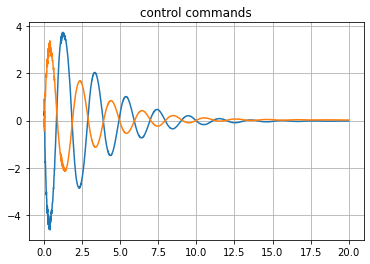

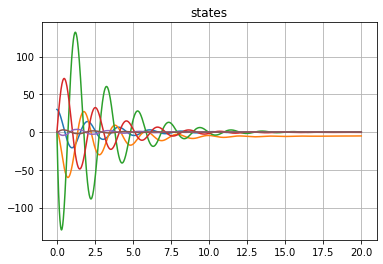

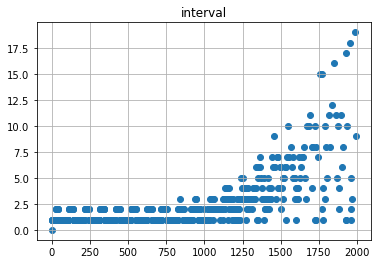

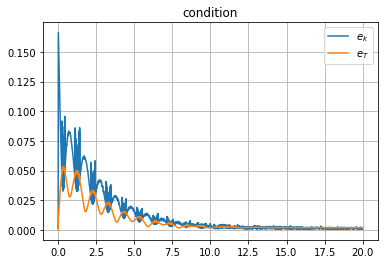

In [8]:
if __name__ == "__main__":


    # train_iters(model, actor, critic, state_now, Q, R, gamma_c, num_epochs)
    for step in tqdm(range(t_steps)):

        time = step*dt
        # measurement noises
        noises = np.array([np.random.randn()*x1_std, np.random.randn()*x2_std, np.random.randn()*x3_std,
        np.random.randn()*x4_std, np.random.randn()*x5_std, np.random.randn()*x6_std])
        state_measure = state_now + noises

        # The following part is the controller
        # The ETC also uses the measured data
        norm_et = np.linalg.norm(state_et_now - state_measure)
        condition_et = rou*norm_state_et*(1-np.power(2*rou,step-step_triggered))/(1-(2*rou))

        if norm_et>condition_et:

            # compute control & update weights
            control_now = train_iters(actor, critic, state_now, Q, R, gamma_c, num_epochs, dt)
            interval_et.append([step,step-step_triggered])
            state_et_now = state_now
            step_triggered = step
            norm_state_et = np.linalg.norm(state_et_now)
            samples_et += 1
        # update system
        control_now = control_now + disturb_sin(step*dt)

        for item in range(len(control_now)):
            if np.abs(control_now[item]) > u_b:
                control_now[item] = np.sign(control_now[item])*u_b 
        state_next = sys_dynamics.f16_lateral(state_now,control_now,dt)

        states.append(state_now*180/np.pi)
        controls.append(control_now*180/np.pi)
        conditions.append([norm_et, condition_et])
        state_now = state_next
    print("Done!")
    print("Event triggered times:", samples_et)
    print("Computation decreases up to:", (t_steps - samples_et)/t_steps*100,"%" )


    steps = np.linspace(0,(t_steps-1)*dt,t_steps)

    plt.figure()
    plt.plot(steps, controls)
    plt.title("control commands")
    plt.grid(axis='both')

    plt.figure()
    plt.plot(steps, states)
    plt.title("states")
    plt.grid(axis='both')


    a = [i[0] for i in interval_et]
    b = [i[1] for i in interval_et]
    plt.figure()
    plt.scatter(a,b)
    plt.title("interval")
    plt.grid(axis='both')

    plt.figure()
    plt.plot(steps, conditions)
    plt.title("condition")
    plt.legend(["$e_k$","$e_T$"])
    plt.grid(axis='both')

    plt.show()

    # print(states)
